In [1]:
#https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers, callbacks

Using TensorFlow backend.


In [2]:
#1. Dataset preparation3. Model Building
# load the dataset
data = open('data/corpus').read()
labels, texts = [], []
for i, line in enumerate(data.split("\n")):
    content = line.split()
    labels.append(content[0])
    texts.append(" ".join(content[1:]))

# create a dataframe using texts and lables
trainDF = pandas.DataFrame()
trainDF['text'] = texts
trainDF['label'] = labels

In [3]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)


In [4]:
print(train_y)

[0 1 1 ... 1 1 1]


In [18]:
#2.1 Count Vectors as features
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
count_vect.fit(trainDF['text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)


In [6]:
xtrain_count.shape

(7500, 5000)

In [34]:
#2.2 TF-IDF Vectors as features
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [27]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,5), max_features=5000)
tfidf_vect_ngram.fit(trainDF['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,5), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x)

In [67]:
#2.3 Word Embeddings
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('data/wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(trainDF['text'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [16]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.0897      0.016      -0.0571     ...  0.1559     -0.0254
  -0.0259    ]
 [-0.0314      0.0149     -0.0205     ...  0.098       0.0893
   0.0148    ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.0897     -0.0682      0.0726     ...  0.206       0.0839
   0.1557    ]
 [-0.0857      0.0475      0.14489999 ...  0.0586      0.11
   0.0743    ]]


In [ ]:
#2.4 Text / NLP based features
trainDF['char_count'] = trainDF['text'].apply(len)
trainDF['word_count'] = trainDF['text'].apply(lambda x: len(x.split()))
trainDF['word_density'] = trainDF['char_count'] / (trainDF['word_count']+1)
trainDF['punctuation_count'] = trainDF['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
trainDF['title_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
trainDF['upper_case_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [ ]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

trainDF['noun_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'noun'))
trainDF['verb_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'verb'))
trainDF['adj_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'adj'))
trainDF['adv_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'adv'))
trainDF['pron_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'pron'))

In [ ]:
#2.5 Topic Models as features
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = numpy.array(vocab)[numpy.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))


In [102]:
#3. Model Building
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)    
    #print(predictions[0:20])
    #print(valid_y[0:20])
    return metrics.accuracy_score(predictions, valid_y)

In [32]:
#3.1 Naive Bayes
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print ("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  0.8408
NB, WordLevel TF-IDF:  0.8344
NB, N-Gram Vectors:  0.8356
NB, CharLevel Vectors:  0.8072


In [12]:
NB, Count Vectors:  0.8488
NB, WordLevel TF-IDF:  0.8524
NB, N-Gram Vectors:  0.8448
NB, CharLevel Vectors:  0.8108

SyntaxError: invalid syntax (<ipython-input-12-166b17a58bdd>, line 1)

In [47]:
#3.2 Linear Classifier
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print ("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("LR, CharLevel Vectors: ", accuracy)

LR, Count Vectors:  0.8548
LR, WordLevel TF-IDF:  0.8584
LR, N-Gram Vectors:  0.8268
LR, CharLevel Vectors:  0.8376


In [61]:
accuracy = train_model(linear_model.LogisticRegression(penalty='l2',C=5.0), xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR, WordLevel TF-IDF: ", accuracy)

LR, WordLevel TF-IDF:  0.862


In [100]:
accuracy = train_model(linear_model.LogisticRegression(), train_seq_x, train_y, valid_seq_x)
print ("LR, Embedding: ", accuracy)

[0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1]
[0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0]
LR, Embedding:  0.4888


In [ ]:
LR, Count Vectors:  0.8688
LR, WordLevel TF-IDF:  0.872
LR, N-Gram Vectors:  0.8364
LR, CharLevel Vectors:  0.8448
LR, Embedding:  0.4888

In [20]:
accuracy = train_model(svm.SVC(kernel='linear'), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy)
accuracy = train_model(svm.SVC(kernel='linear'), xtrain_count, train_y, xvalid_count)
print ("SVM,WordLevel WordCount: ", accuracy)
accuracy = train_model(svm.SVC(kernel='linear'), xtrain_tfidf, train_y, xvalid_tfidf)
print ("SVM,WordLevel TF-IDF: ", accuracy)
accuracy = train_model(svm.SVC(kernel='linear'), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("SVM,CharLevel Vectors: ", accuracy)

SVM, N-Gram Vectors:  0.8256
SVM,WordLevel WordCount:  0.824
SVM,WordLevel TF-IDF:  0.8652
SVM,CharLevel Vectors:  0.8384


In [ ]:
SVM, N-Gram Vectors:  0.8168
SVM,WordLevel WordCount:  0.8464
SVM,WordLevel TF-IDF:  0.87
SVM,CharLevel Vectors:  0.8352

In [21]:
#3.3 Implementing a SVM Model
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(C=100.0, gamma= 0.001), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy)
accuracy = train_model(svm.SVC(C=100.0, gamma= 0.001), xtrain_count, train_y, xvalid_count)
print ("SVM,Count Vectors: ", accuracy)
accuracy = train_model(svm.SVC(C=100.0, gamma= 0.001), xtrain_tfidf, train_y, xvalid_tfidf)
print ("SVM,WordLevel TF-IDF: ", accuracy)
accuracy = train_model(svm.SVC(C=100.0, gamma= 0.001), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("SVM,CharLevel Vectors: ", accuracy)

SVM, N-Gram Vectors:  0.8248
SVM,Count Vectors:  0.8488
SVM,WordLevel TF-IDF:  0.8568
SVM,CharLevel Vectors:  0.8312


In [ ]:
SVM, N-Gram Vectors:  0.84
SVM,Count Vectors:  0.856
SVM,WordLevel TF-IDF:  0.8704
SVM,CharLevel Vectors:  0.836

In [ ]:
#3.4 Bagging Model
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=100,criterion='entropy'), xtrain_count, train_y, xvalid_count)
print ("RF, Count Vectors: ", accuracy)
# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=100,criterion='entropy'), xtrain_tfidf, train_y, xvalid_tfidf)
print ("RF, WordLevel TF-IDF: ", accuracy)

In [ ]:
RF, Count Vectors:  0.8464
RF, WordLevel TF-IDF:  0.8344

In [101]:
#3.5 Boosting Model
# Extereme Gradient Boosting on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(max_depth=7,
                           min_child_weight=1,
                           learning_rate=0.1,
                           n_estimators=500,
                           silent=True,
                           objective='binary:logistic',
                           gamma=0,
                           max_delta_step=0,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           reg_alpha=0,
                           reg_lambda=0,
                           scale_pos_weight=1,
                           seed=1,
                           missing=None), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print ("Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier( learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy)

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print ("Xgb, CharLevel Vectors: ", accuracy)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0]
[0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0]
Xgb, Count Vectors:  0.8452


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0]
[0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0]
Xgb, WordLevel TF-IDF:  0.8288
[0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 0 1 1 1 0]
[0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0]
Xgb, CharLevel Vectors:  0.8048


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [116]:
# Extereme Gradient Boosting on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print ("Xgb, TF IDF Vectors: ", accuracy)

Xgb, TF IDF Vectors:  0.832


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
Xgb, Count Vectors: 0.8584
Xgb, WordLevel TF-IDF: 0.8356
Xgb, CharLevel Vectors:  0.8152
Xgb, TF IDF Vectors:  0.8284

In [37]:
from sklearn.model_selection import GridSearchCV
import numpy as np


In [38]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge

In [39]:
linear_model.LogisticRegression().get_params().keys()

dict_keys(['verbose', 'dual', 'multi_class', 'class_weight', 'n_jobs', 'solver', 'intercept_scaling', 'fit_intercept', 'random_state', 'penalty', 'warm_start', 'C', 'tol', 'max_iter'])

In [40]:
gs_clf = GridSearchCV(linear_model.LogisticRegression(), grid,cv=10)
gs_clf = gs_clf.fit(xtrain_tfidf, train_y)

In [42]:
gs_clf.best_score_
gs_clf.best_params_
gs_clf.grid_scores_

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.50840, std: 0.00033, params: {'C': 0.001, 'penalty': 'l1'},
 mean: 0.51147, std: 0.00139, params: {'C': 0.001, 'penalty': 'l2'},
 mean: 0.50840, std: 0.00033, params: {'C': 0.01, 'penalty': 'l1'},
 mean: 0.78240, std: 0.01031, params: {'C': 0.01, 'penalty': 'l2'},
 mean: 0.73800, std: 0.01651, params: {'C': 0.1, 'penalty': 'l1'},
 mean: 0.83280, std: 0.01263, params: {'C': 0.1, 'penalty': 'l2'},
 mean: 0.84867, std: 0.01308, params: {'C': 1.0, 'penalty': 'l1'},
 mean: 0.86747, std: 0.00983, params: {'C': 1.0, 'penalty': 'l2'},
 mean: 0.85293, std: 0.01121, params: {'C': 10.0, 'penalty': 'l1'},
 mean: 0.86773, std: 0.01155, params: {'C': 10.0, 'penalty': 'l2'},
 mean: 0.83267, std: 0.01105, params: {'C': 100.0, 'penalty': 'l1'},
 mean: 0.84840, std: 0.01099, params: {'C': 100.0, 'penalty': 'l2'},
 mean: 0.83213, std: 0.00951, params: {'C': 1000.0, 'penalty': 'l1'},
 mean: 0.83920, std: 0.01373, params: {'C': 1000.0, 'penalty': 'l2'}]

In [117]:
param_test = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}

In [119]:
gsearch = GridSearchCV(estimator = xgboost.XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=1, colsample_bytree=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

In [ ]:
train_model4 = gsearch.fit(xtrain_tfidf, train_y)

In [ ]:
train_model4.

In [ ]:
#3. Model Building
def train_model_new(classifier, feature_vector_train, label, feature_vector_valid, epoch, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label,epochs=epoch)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)  
    predictions = [1 if x >= 0.5 else 0 for x in predictions]
    #if is_neural_net:
        #predictions = predictions.argmax(axis=1)
    
    #print(predictions)
    #print(valid_y)
    #print(metrics.accuracy_score(valid_y,predictions))
    return metrics.roc_auc_score(valid_y,predictions) 

In [ ]:
#3.6 Shallow Neural Networks
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(1000, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
    return classifier 

classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])
accuracy = train_model_new(classifier, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram,4, is_neural_net=True)
print ("NN, Ngram Level TF IDF Vectors",  accuracy)

In [ ]:
Epoch 1/1
7500/7500 [==============================] - 8s 1ms/step - loss: 0.5251
NN, Ngram Level TF IDF Vectors 0.5016

Epoch 1/20
7500/7500 [==============================] - 5s 709us/step - loss: 0.5273 - acc: 0.7760
Epoch 2/20
7500/7500 [==============================] - 4s 470us/step - loss: 0.2785 - acc: 0.8925
Epoch 3/20
7500/7500 [==============================] - 4s 487us/step - loss: 0.1936 - acc: 0.9320
Epoch 4/20
7500/7500 [==============================] - 3s 390us/step - loss: 0.1423 - acc: 0.9543
Epoch 5/20
7500/7500 [==============================] - 3s 385us/step - loss: 0.1046 - acc: 0.9719
Epoch 6/20
7500/7500 [==============================] - 3s 382us/step - loss: 0.0752 - acc: 0.9845
Epoch 7/20
7500/7500 [==============================] - 3s 385us/step - loss: 0.0527 - acc: 0.9931
Epoch 8/20
7500/7500 [==============================] - 3s 382us/step - loss: 0.0368 - acc: 0.9968
Epoch 9/20
7500/7500 [==============================] - 3s 381us/step - loss: 0.0259 - acc: 0.9979
Epoch 10/20
7500/7500 [==============================] - 3s 447us/step - loss: 0.0188 - acc: 0.9987
Epoch 11/20
7500/7500 [==============================] - 3s 466us/step - loss: 0.0141 - acc: 0.9987
Epoch 12/20
7500/7500 [==============================] - 4s 517us/step - loss: 0.0111 - acc: 0.9988
Epoch 13/20
7500/7500 [==============================] - 5s 624us/step - loss: 0.0090 - acc: 0.9988
Epoch 14/20
7500/7500 [==============================] - 4s 472us/step - loss: 0.0075 - acc: 0.9988
Epoch 15/20
7500/7500 [==============================] - 4s 473us/step - loss: 0.0064 - acc: 0.9988
Epoch 16/20
7500/7500 [==============================] - 4s 474us/step - loss: 0.0056 - acc: 0.9988
Epoch 17/20
7500/7500 [==============================] - 4s 480us/step - loss: 0.0050 - acc: 0.9988
Epoch 18/20
7500/7500 [==============================] - 4s 476us/step - loss: 0.0045 - acc: 0.9987
Epoch 19/20
7500/7500 [==============================] - 4s 478us/step - loss: 0.0041 - acc: 0.9987
Epoch 20/20
7500/7500 [==============================] - 4s 478us/step - loss: 0.0038 - acc: 0.9987
NN, Ngram Level TF IDF Vectors 0.8967110726366244

In [ ]:
#3.7 Deep Neural Networks
#3.7.1 Convolutional Neural Network
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
    
    return model

classifier = create_cnn()
accuracy = train_model_new(classifier, train_seq_x, train_y, valid_seq_x, 4, is_neural_net=True)
print ("CNN, Word Embeddings",  accuracy)

In [ ]:
Epoch 1/1
7500/7500 [==============================] - 17s 2ms/step - loss: 0.5841
CNN, Word Embeddings 0.5016

Epoch 1/20
7500/7500 [==============================] - 14s 2ms/step - loss: 0.5549
Epoch 2/20
7500/7500 [==============================] - 12s 2ms/step - loss: 0.3796
Epoch 3/20
7500/7500 [==============================] - 13s 2ms/step - loss: 0.3206
Epoch 4/20
7500/7500 [==============================] - 12s 2ms/step - loss: 0.2778
Epoch 5/20
7500/7500 [==============================] - 13s 2ms/step - loss: 0.2384
Epoch 6/20
7500/7500 [==============================] - 13s 2ms/step - loss: 0.1917
Epoch 7/20
7500/7500 [==============================] - 13s 2ms/step - loss: 0.1575
Epoch 8/20
7500/7500 [==============================] - 14s 2ms/step - loss: 0.1238
Epoch 9/20
7500/7500 [==============================] - 14s 2ms/step - loss: 0.1015
Epoch 10/20
7500/7500 [==============================] - 13s 2ms/step - loss: 0.0889
Epoch 11/20
7500/7500 [==============================] - 13s 2ms/step - loss: 0.0688
Epoch 12/20
7500/7500 [==============================] - 13s 2ms/step - loss: 0.0716
Epoch 13/20
7500/7500 [==============================] - 13s 2ms/step - loss: 0.0612
Epoch 14/20
7500/7500 [==============================] - 14s 2ms/step - loss: 0.0563
Epoch 15/20
7500/7500 [==============================] - 13s 2ms/step - loss: 0.0523
Epoch 16/20
7500/7500 [==============================] - 14s 2ms/step - loss: 0.0483
Epoch 17/20
7500/7500 [==============================] - 13s 2ms/step - loss: 0.0537
Epoch 18/20
7500/7500 [==============================] - 15s 2ms/step - loss: 0.0442
Epoch 19/20
7500/7500 [==============================] - 14s 2ms/step - loss: 0.0456
Epoch 20/20
7500/7500 [==============================] - 12s 2ms/step - loss: 0.0425
(2500, 1)
[7.8318059e-01 9.9925035e-01 6.1134610e-04 9.9998665e-01 9.9999905e-01
 9.9962318e-01 9.9859709e-01 9.9917930e-01 7.0752937e-01 9.9864143e-01
 9.6448255e-01 1.1390647e-04 9.6624172e-01 5.3794348e-01 9.9877435e-01
 6.1611372e-01 9.9974352e-01 1.3516644e-06 8.7371105e-01 7.7482120e-08]
[1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 1 0 1 0]
CNN, Word Embeddings 0.9373635358053192


In [ ]:
#3.7.2 Recurrent Neural Network – LSTM
# Add an Input Layer
def create_rnn_lstm():
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
    
    return model

classifier = create_rnn_lstm()
accuracy = train_model_new(classifier, train_seq_x, train_y, valid_seq_x, 20, is_neural_net=True)
print ("RNN-LSTM, Word Embeddings",  accuracy)

In [ ]:
Epoch 1/20
7500/7500 [==============================] - 30s 4ms/step - loss: 0.5878 - acc: 0.6832
Epoch 2/20
7500/7500 [==============================] - 33s 4ms/step - loss: 0.5014 - acc: 0.7619
Epoch 3/20
7500/7500 [==============================] - 32s 4ms/step - loss: 0.4734 - acc: 0.7832
Epoch 4/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.4569 - acc: 0.7856
Epoch 5/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.4377 - acc: 0.7977
Epoch 6/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.4178 - acc: 0.8145
Epoch 7/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.3922 - acc: 0.8229
Epoch 8/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.3734 - acc: 0.8315
Epoch 9/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.3548 - acc: 0.8428
Epoch 10/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.3319 - acc: 0.8535
Epoch 11/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.3195 - acc: 0.8592
Epoch 12/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.3079 - acc: 0.8683
Epoch 13/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.2907 - acc: 0.8735
Epoch 14/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.2714 - acc: 0.8859
Epoch 15/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.2528 - acc: 0.8923
Epoch 16/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.2457 - acc: 0.8949
Epoch 17/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.2277 - acc: 0.9029
Epoch 18/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.2167 - acc: 0.9093
Epoch 19/20
7500/7500 [==============================] - 27s 4ms/step - loss: 0.2068 - acc: 0.9111
Epoch 20/20
7500/7500 [==============================] - 28s 4ms/step - loss: 0.1888 - acc: 0.9235
(2500, 1)
[[5.6749523e-02]
 [8.3308637e-01]
 [9.9879092e-01]
 [9.9999177e-01]
 [2.0139949e-02]
 [3.8266245e-02]
 [5.1640469e-04]
 [5.4006672e-01]
 [4.0028162e-02]
 [3.0131629e-01]
 [4.0146457e-05]
 [9.9299735e-01]
 [9.9577868e-01]
 [2.2251075e-02]
 [9.9274325e-01]
 [9.9896109e-01]
 [9.9785280e-01]
 [9.9829048e-01]
 [2.9750664e-03]
 [5.2361798e-01]]
[0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]
[0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0]
RNN-LSTM, Word Embeddings 0.8376

In [ ]:
#3.7.3 Recurrent Neural Network – GRU
def create_rnn_gru():
        # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the GRU Layer
    lstm_layer = layers.GRU(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_gru()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("RNN-GRU, Word Embeddings",  accuracy)

In [ ]:
Epoch 1/1
7500/7500 [==============================] - 93s 12ms/step - loss: 0.6193
RNN-GRU, Word Embeddings 0.5016

In [ ]:
#3.7.4 Bidirectional RNN
def create_bidirectional_rnn():
        # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.Bidirectional(layers.GRU(100))(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_bidirectional_rnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("RNN-Bidirectional, Word Embeddings",  accuracy)

In [ ]:
Epoch 1/1
7500/7500 [==============================] - 63s 8ms/step - loss: 0.6233
RNN-Bidirectional, Word Embeddings 0.5016

In [ ]:
#3.7.5 Recurrent Convolutional Neural Network
def create_rcnn():
        # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
    
    # Add the recurrent layer
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rcnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("CNN, Word Embeddings",  accuracy)

In [ ]:
Epoch 1/1
7500/7500 [==============================] - 16s 2ms/step - loss: 0.5710
CNN, Word Embeddings 0.5016

In [56]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras import regularizers

regularizers.l1_l2(l1=0.001, l2=0.001)
model = Sequential()
model.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False,input_length=70))
#model.add(Dropout(0.5))
model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 70, 300)           10041000  
_________________________________________________________________
flatten_14 (Flatten)         (None, 21000)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)                672032    
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 33        
Total params: 10,713,065
Trainable params: 672,065
Non-trainable params: 10,041,000
_________________________________________________________________


In [57]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
               metrics=['acc'])
history = model.fit(train_seq_x, train_y,
                    epochs=10,
                    batch_size=32,
                    validation_data=(valid_seq_x, valid_y))

Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 34s 4ms/step - loss: 0.6687 - acc: 0.6573 - val_loss: 0.6397 - val_acc: 0.7040
Epoch 2/10
7500/7500 [==============================] - 6s 793us/step - loss: 0.5113 - acc: 0.8219 - val_loss: 0.6824 - val_acc: 0.7064
Epoch 3/10
7500/7500 [==============================] - 6s 807us/step - loss: 0.4308 - acc: 0.8824 - val_loss: 0.6499 - val_acc: 0.7540
Epoch 4/10
7500/7500 [==============================] - 6s 794us/step - loss: 0.3947 - acc: 0.9125 - val_loss: 0.6810 - val_acc: 0.7564
Epoch 5/10
7500/7500 [==============================] - 6s 791us/step - loss: 0.3625 - acc: 0.9257 - val_loss: 0.7546 - val_acc: 0.7448
Epoch 6/10
7500/7500 [==============================] - 6s 800us/step - loss: 0.3446 - acc: 0.9345 - val_loss: 0.7240 - val_acc: 0.7572
Epoch 7/10
7500/7500 [==============================] - 7s 887us/step - loss: 0.3273 - acc: 0.9435 - val_loss: 0.8819 - val_acc: 0.7220
E

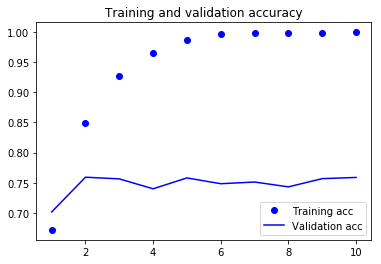

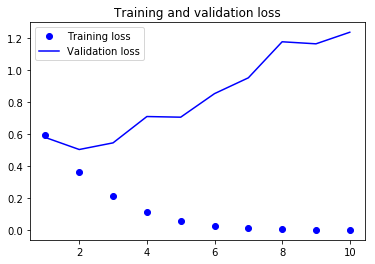

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

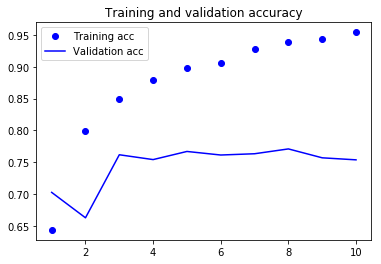

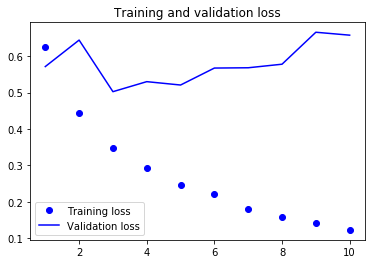

In [25]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

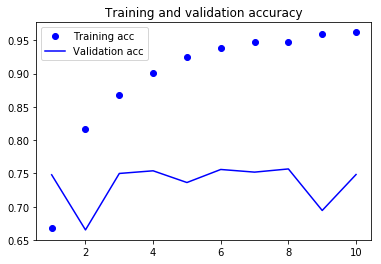

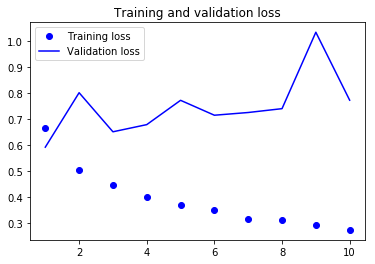

In [30]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

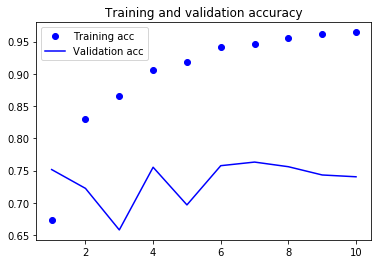

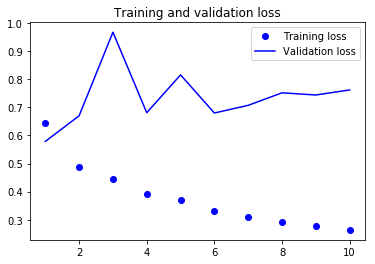

In [33]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [88]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, GlobalAveragePooling1D

model = Sequential()
model.add(layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False,input_length=70))
model.add(layers.GlobalAveragePooling1D())
#model.add(Flatten())
model.add(layers.Dense(300, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 70, 300)           10041000  
_________________________________________________________________
global_average_pooling1d_7 ( (None, 300)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_15 (Dense)             (None, 30)                9030      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 31        
Total params: 10,140,361
Trainable params: 99,361
Non-trainable params: 10,041,000
_________________________________________________________________


In [89]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [91]:
history = model.fit(train_seq_x, train_y,
                    epochs=10,
                    batch_size=32,
                    validation_data=(valid_seq_x, valid_y))

Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 2s 250us/step - loss: 0.4126 - acc: 0.8164 - val_loss: 0.4151 - val_acc: 0.8052
Epoch 2/10
7500/7500 [==============================] - 2s 238us/step - loss: 0.3957 - acc: 0.8249 - val_loss: 0.4113 - val_acc: 0.8068
Epoch 3/10
7500/7500 [==============================] - 2s 239us/step - loss: 0.3875 - acc: 0.8297 - val_loss: 0.4087 - val_acc: 0.8188
Epoch 4/10
7500/7500 [==============================] - 2s 241us/step - loss: 0.3775 - acc: 0.8317 - val_loss: 0.4103 - val_acc: 0.8128
Epoch 5/10
7500/7500 [==============================] - 2s 240us/step - loss: 0.3751 - acc: 0.8344 - val_loss: 0.4006 - val_acc: 0.8148
Epoch 6/10
7500/7500 [==============================] - 2s 243us/step - loss: 0.3685 - acc: 0.8373 - val_loss: 0.4016 - val_acc: 0.8208
Epoch 7/10
7500/7500 [==============================] - 2s 242us/step - loss: 0.3612 - acc: 0.8388 - val_loss: 0.4005 - val_acc: 0.8224


In [92]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [94]:
history = model.fit(train_seq_x, train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(valid_seq_x, valid_y))

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 2s 237us/step - loss: 0.2608 - acc: 0.8909 - val_loss: 0.4224 - val_acc: 0.8264
Epoch 2/20
7500/7500 [==============================] - 2s 237us/step - loss: 0.2496 - acc: 0.8953 - val_loss: 0.4262 - val_acc: 0.8180
Epoch 3/20
7500/7500 [==============================] - 2s 236us/step - loss: 0.2418 - acc: 0.8989 - val_loss: 0.4702 - val_acc: 0.8036
Epoch 4/20
7500/7500 [==============================] - 2s 236us/step - loss: 0.2307 - acc: 0.9055 - val_loss: 0.4909 - val_acc: 0.8204
Epoch 5/20
7500/7500 [==============================] - 2s 235us/step - loss: 0.2230 - acc: 0.9084 - val_loss: 0.4786 - val_acc: 0.8192
Epoch 6/20
7500/7500 [==============================] - 2s 231us/step - loss: 0.2133 - acc: 0.9136 - val_loss: 0.4647 - val_acc: 0.8264
Epoch 7/20
7500/7500 [==============================] - 2s 240us/step - loss: 0.2039 - acc: 0.9183 - val_loss: 0.4767 - val_acc: 0.8184
